In [ ]:
import pandas as pd # 데이터프레임 형태를 다룰 수 있는 라이브러리
import numpy as np
from sklearn.model_selection import train_test_split # 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
from sklearn.preprocessing import  MinMaxScaler
# ANN
import torch
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import torch.nn.functional as F # torch 내의 세부적인 기능을 불러온다. (신경망 기술 등)

# Loss
from sklearn.metrics import mean_squared_error # Regression 문제의 평가를 위해 MSE(Mean Squared Error)를 불러온다.

# Plot
import matplotlib.pyplot as plt # 시각화 도구


In [ ]:
file_name = '/AllData.xlsx'
df = pd.read_excel(file_name)
display(df)

,시군구,읍면동,번지,본번,부번,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,대규모 점포,근린 공원,반려동물 등록수,병원,학교,station,starbucks
0,인천광역시 강화군 강화읍 갑곳리,강화읍,165-1,165,1,114.86,202105,3,"21,500",4,2001,갑룡길 35,0,0,1245,21,15,0,1
1,인천광역시 강화군 강화읍 갑곳리,강화읍,165-1,165,1,84.89,202107,29,"21,200",12,2001,갑룡길 35,0,0,1245,21,15,0,1
2,인천광역시 강화군 강화읍 갑곳리,강화읍,165-1,165,1,59.99,202108,27,"10,000",6,2001,갑룡길 35,0,0,1245,21,15,0,1
3,인천광역시 강화군 강화읍 갑곳리,강화읍,165-1,165,1,59.99,202108,27,"10,000",6,2001,갑룡길 35,0,0,1245,21,15,0,1
4,인천광역시 강화군 강화읍 갑곳리,강화읍,165-1,165,1,114.86,202109,19,"22,500",2,2001,갑룡길 35,0,0,1245,21,15,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24449,인천광역시 중구 항동7가,항동,91-2,91,2,53.66,202111,26,"34,000",5,1983,축항대로 234,0,0,504,8,2,0,0
24450,인천광역시 중구 항동7가,항동,91-2,91,2,53.66,202111,26,"34,000",5,1983,축항대로 234,0,0,504,8,2,0,0
24451,인천광역시 중구 항동7가,항동,91-2,91,2,53.66,202112,8,"32,000",3,1983,축항대로 234,0,0,504,8,2,0,0
24452,인천광역시 중구 항동7가,항동,91-2,91,2,53.66,202112,9,"34,000",5,1983,축항대로 234,0,0,504,8,2,0,0


In [ ]:
df.columns # 변수 명 확인 

Index(['시군구', '읍면동', '번지', '본번', '부번', '전용면적(㎡)', '계약년월', '계약일', '거래금액(만원)',
       '층', '건축년도', '도로명', '대규모 점포', '근린 공원', '반려동물 등록수', '병원', '학교',
       'station', 'starbucks'],
      dtype='object')

In [ ]:
print(df['거래금액(만원)']) # 우리가 타겟 값으로 지정할 거래금액 (정답 지)
df.head()
df.info()

0                21,500
1                21,200
2                10,000
3                10,000
4                22,500
              ...      
24449            34,000
24450            34,000
24451            32,000
24452            34,000
24453            32,600
Name: 거래금액(만원), Length: 24454, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24454 entries, 0 to 24453
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   시군구        24454 non-null  object 
 1   읍면동        24454 non-null  object 
 2   번지         24454 non-null  object 
 3   본번         24454 non-null  int64  
 4   부번         24454 non-null  int64  
 5   전용면적(㎡)    24454 non-null  float64
 6   계약년월       24454 non-null  int64  
 7   계약일        24454 non-null  int64  
 8   거래금액(만원)   24454 non-null  object 
 9   층          24454 non-null  int64  
 10  건축년도       24454 non-null  int64  
 11  도로명        24454 non-null  object 
 12  대규모 점포     24454 

# 데이터 스케일링(MinMax Scale)

In [ ]:
df_copy = df.copy();
drop_list = ['번지','본번','부번','계약일', '읍면동','도로명']
for i in drop_list:
  df_copy = df_copy.drop(i, axis= 1) # 필요 없는 특성은 df에서 제거해준다. 
df_copy['거래금액(만원)'] = df_copy['거래금액(만원)'].str.replace(',','')
df_copy.rename(columns={'전용면적(㎡)':'전용면적', '거래금액(만원)': '거래금액'}, inplace=True) # 이름 재정의 
df_copy['시군구'] = df_copy['시군구'].astype('category').cat.rename_categories({string : i for i,string in enumerate(df_copy['시군구'].unique())})
df_copy['전용면적'] = df_copy['전용면적'].astype('float32')
df_copy['계약년월'] = df_copy['계약년월'].astype('float32')
df_copy['거래금액'] = df_copy['거래금액'].astype('float32')
df_copy['층'] = df_copy['층'].astype('float32')
df_copy['건축년도'] = df_copy['건축년도'].astype('float32')
df_copy['대규모 점포'] = df_copy['대규모 점포'].astype('float32')
df_copy['근린 공원'] = df_copy['근린 공원'].astype('float32')
df_copy['반려동물 등록수'] = df_copy['반려동물 등록수'].astype('float32')
df_copy['병원'] = df_copy['병원'].astype('float32')
df_copy['학교'] = df_copy['학교'].astype('float32')
df_copy['station'] = df_copy['station'].astype('float32')
df_copy['starbucks'] = df_copy['starbucks'].astype('float32')
df_copy.head()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24454 entries, 0 to 24453
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   시군구        24454 non-null  category
 1   전용면적       24454 non-null  float32 
 2   계약년월       24454 non-null  float32 
 3   거래금액       24454 non-null  float32 
 4   층          24454 non-null  float32 
 5   건축년도       24454 non-null  float32 
 6   대규모 점포     24454 non-null  float32 
 7   근린 공원      24454 non-null  float32 
 8   반려동물 등록수   24454 non-null  float32 
 9   병원         24454 non-null  float32 
 10  학교         24454 non-null  float32 
 11  station    24454 non-null  float32 
 12  starbucks  24454 non-null  float32 
dtypes: category(1), float32(12)
memory usage: 1.1 MB


In [ ]:
df_copy_make = df_copy.filter(['전용면적', '계약년월', '거래금액', '층','건축년도','대규모 점포','근린 공원','반려동물 등록수', '병원','학교','station','starbucks'])
df_copy_make.info()
X = df_copy_make.drop('거래금액', axis=1).to_numpy() #데이터 프레임에서 타겟값(거래금액(만원))을 제외하고 넘파이 배열로 만들어준다.
Y = df_copy_make['거래금액'].to_numpy().reshape((-1,1)) # 데이터 프레임 형태의 타겟 값을 넘파이 배열로 만들어준다.
#데이터 스케일링
#sklearn에서 제공하는 MinMaxScaler
#(X- min(X)) / (max(X)-min(X))을 계산 
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

scaler.fit(Y)
Y = scaler.transform(Y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24454 entries, 0 to 24453
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   전용면적       24454 non-null  float32
 1   계약년월       24454 non-null  float32
 2   거래금액       24454 non-null  float32
 3   층          24454 non-null  float32
 4   건축년도       24454 non-null  float32
 5   대규모 점포     24454 non-null  float32
 6   근린 공원      24454 non-null  float32
 7   반려동물 등록수   24454 non-null  float32
 8   병원         24454 non-null  float32
 9   학교         24454 non-null  float32
 10  station    24454 non-null  float32
 11  starbucks  24454 non-null  float32
dtypes: float32(12)
memory usage: 1.1 MB


# 텐서 데이터와 배치 만들기 

In [ ]:
#데이터를 텐셔 형태로 변환해주는 클래스 
class TensorData(Dataset):
  def __init__(self, x_data, y_data):
    self.x_data = torch.FloatTensor(x_data)# Double Tensor는 Float64로 변환 Float Tensor는 Float32로 변환 
    self.y_data = torch.FloatTensor(y_data)
    self.len = self.y_data.shape[0]

  def __getitem__(self, index) :
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.len

In [ ]:
#scikit-learn 을 이용해서 학습 데이터와 평가 데이터로 나눈다. 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size= 0.5) # hyper parameter 테스트 사이즈
# train데이터와 validation 데이터로 나눈다. 
X2_train, X_val, Y2_train, Y_val = train_test_split(X_train, Y_train)
#학습 데이터랑 시험데이터를 배치 형태로 구축한다.
print(X2_train.shape)
print(X2_train.ndim)
print(X_val.shape)
print(Y2_train.shape)
print(Y2_train.ndim)
print(Y_val.shape)
trainsets = TensorData(X2_train, Y2_train)
trainLoader = torch.utils.data.DataLoader(trainsets, batch_size = 32, shuffle=True) # 하이퍼 파라미터 배치 사이즈 

validationsets = TensorData(X_val, Y_val) #validation set
validationLoader = torch.utils.data.DataLoader(validationsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test) # 테스트 데이터들을 나눠준다. 
testloader = torch.utils.data.DataLoader(testsets, batch_size = 32, shuffle=True) 

(9170, 11)
2
(3057, 11)
(9170, 1)
2
(3057, 1)


# 모델 구축 

In [ ]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(11, 50, bias=True) # 입력층(11) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(50, 30, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(30, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.

    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
        x = self.dropout(F.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
      
        return x

  #drop out 은 과적합(overfitting)을 방지하기 위해 노드의 이부를 배제하고 계산하는 방식이기 때문에 출력층에 사용하면 안된다. 


# 모델, 손실함수, 최적화 방법 선언

In [ ]:
model = Regressor()
criterion = nn.MSELoss() # hyper parameter 활성화 함수 종류

#lr == learning rate
#weight_decay는 L2 정규화에서의 penalty 정도

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)#하이퍼 파라미터 lr weight decay optimizer 종류


# 학습진행

In [ ]:
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(trainLoader)

for epoch in range(400): # 400번 학습을 진행한다.

    running_loss = 0.0
    
    for i, data in enumerate(trainLoader, 0): # 무작위로 섞인 32개 데이터가 있는 배치가 하나 씩 들어온다.

        inputs, values = data # data에는 X, Y가 들어있다.

        optimizer.zero_grad() # 최적화 초기화
        
        outputs = model(inputs) # 모델에 입력값 대입 후 예측값 산출
        loss = criterion(outputs, values) # 손실 함수 계산
        loss.backward() # 손실 함수 기준으로 역전파 설정 
        optimizer.step() # 역전파를 진행하고 가중치 업데이트
        running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
 
    print(running_loss)
    loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산

        
print('Finished Training')

0.49143325971090235
0.1649534661846701
0.15387599371024407
0.14997298807429615
0.14682645771245006
0.14588561821437906
0.14047396641399246
0.1379479398165131
0.13446115427359473
0.13009290061017964
0.1275899594038492
0.12366776481212582
0.12379857826454099
0.12238418187916977
0.11759313025686424
0.11426799699256662
0.11538795833621407
0.11329719502828084
0.11083065284765325
0.10879318248771597
0.10633669662638567
0.10485817532753572
0.10648560334084323
0.10524400995200267
0.10474222042830661
0.10055020696745487
0.1014012938758242
0.09798427649366204
0.09775116753735347
0.09538871910626767
0.09455823338066693
0.09588364195951726
0.09429286783415591
0.09219873168331105
0.09229686485923594
0.09108991629909724
0.09135500608681468
0.09292773815104738
0.08853527056635357
0.08632618268893566
0.08735793482628651
0.08652139421610627
0.0874333837928134
0.08622639680834254
0.08587697183247656
0.08501934691594215
0.08547460220870562
0.08316434438893339
0.08182350046990905
0.08317196971620433
0.081

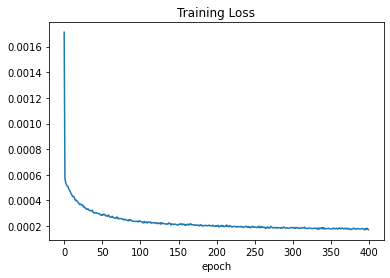

In [ ]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
#valscore = model.evaluate(X_val, Y_val, verbose =1)
#print('정답률 = ', valscore[1],'loss=', valscore[0])

# 모델 평가


In [ ]:
#predictions = torch.tensor([]) # 예측 값을 저장하는 tensor
#actual = torch.tensor([]) # 실제 정답을 저장하는 tensor
def evaluation(dataLoader):
  predictions = torch.tensor([]) # 예측 값을 저장하는 tensor
  actual = torch.tensor([]) # 실제 정답을 저장하는 tensor

  with torch.no_grad():
    model.eval() #평가를 할 때는 .eval()을 반드시 사용
    for data in dataLoader:
      inputs, values = data
      outputs = model(inputs)
      print(outputs)
      predictions = torch.cat((predictions, outputs), 0) #cat을 통해 예측값을 누적
      actual = torch.cat((actual, values), 0)
  predictions = predictions.numpy()
  actual = actual.numpy()
  #print(predictions)
  #print(actual)
  rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용해서 RMSE
  return rmse
evaluation(trainLoader) 
#평가 시 , eval()
#평가 시에는 온전한 모델로 평가를 해야하는데, .eval()이 아닌, .train()의 경우 드랍아웃이 활성화 되어있다. 
#따라서 드랍아웃이나 배치 정규화 등과 같이 학습 시에만 사용하는 기술들을 평가 시에는 비활성화 해야한다. 

Streaming output truncated to the last 5000 lines.
        [0.1884],
        [0.0357],
        [0.1415],
        [0.0439],
        [0.0834],
        [0.0926],
        [0.0497],
        [0.0985],
        [0.0368],
        [0.0502],
        [0.0989],
        [0.0247],
        [0.0493],
        [0.0592],
        [0.1953],
        [0.0000],
        [0.0358],
        [0.0593],
        [0.1947],
        [0.1417],
        [0.0361],
        [0.1401]])
tensor([[0.1100],
        [0.0695],
        [0.1263],
        [0.0458],
        [0.0880],
        [0.0289],
        [0.1423],
        [0.0860],
        [0.0901],
        [0.0491],
        [0.0425],
        [0.0392],
        [0.1474],
        [0.0709],
        [0.0518],
        [0.0273],
        [0.0825],
        [0.1367],
        [0.0620],
        [0.0349],
        [0.0328],
        [0.1187],
        [0.0415],
        [0.1308],
        [0.0447],
        [0.1987],
        [0.0296],
        [0.2060],
        [0.1170],
        [0.0539],
        [0.2

0.013992627

In [ ]:
train_rmse = evaluation(trainLoader) #학습 데이터의 RMSE
vali_rmse = evaluation(validationLoader) #validation의 RMSE
test_rmse = evaluation(testloader)
print("Train RMSE: ", train_rmse)
print("Vali RMSE: ", vali_rmse)
print("Test RMSE: ", test_rmse)

Streaming output truncated to the last 5000 lines.
        [0.0532],
        [0.0836]])
tensor([[0.1025],
        [0.0640],
        [0.0450],
        [0.1319],
        [0.0373],
        [0.0676],
        [0.1518],
        [0.0263],
        [0.0188],
        [0.0639],
        [0.1007],
        [0.1179],
        [0.0651],
        [0.1135],
        [0.0548],
        [0.1413],
        [0.0649],
        [0.0644],
        [0.1539],
        [0.0596],
        [0.1447],
        [0.0302],
        [0.0466],
        [0.0448],
        [0.2668],
        [0.0738],
        [0.1420],
        [0.0591],
        [0.0600],
        [0.0312],
        [0.0742],
        [0.0415]])
tensor([[0.0553],
        [0.0491],
        [0.0474],
        [0.0635],
        [0.0095],
        [0.0647],
        [0.0675],
        [0.0422],
        [0.0538],
        [0.0475],
        [0.0815],
        [0.0436],
        [0.1183],
        [0.0815],
        [0.0543],
        [0.0517],
        [0.0955],
        [0.1245],
        [0.